In [1]:
import glob              as gb
import matplotlib        as mp
import matplotlib.pyplot as plt
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
import warnings          as ws


# Some figure options for later
mp.rcParams["xtick.labelsize"] = 14
mp.rcParams["ytick.labelsize"] = 14

def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import os
    import subprocess

    # Depending on platform
    if os.sys.platform == "darwin":
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform

        mac_ver = ".".join(platform.mac_ver()[0].split(".")[:2])
        env = dict(os.environ, **{"MACOSX_DEPLOYMENT_TARGET": mac_ver})
        print("setting MACOSX_DEPLOYMENT_TARGET to: " + mac_ver)
    else:
        env = os.environ

    optdefs = "OPTIONDEFS = "
    if options is not None:
        optdefs = optdefs + " ".join(["-D" + item for item in options])
        print("Compiling with options: " + optdefs)
    # Clean environment of previous model files
    runmake = subprocess.Popen(
        ["make", "clean"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    # Compile 
    runmake = subprocess.Popen(
        ["make", "pymodel", optdefs],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    print("The exit code for compilations was: %d" % runmake.returncode)
    return runmake.returncode

def get_ligand_parameters(fadd="",gamma_over_lambda=4398.0,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0):
    if gamma_over_lambda > 0.0:
        # Assume this means prognostic ligand required
        fadd       = fadd + "variablelt"
        # Gamma over lambda for ligands "optimum" value (Lauderdale et al 2020)    
        # gamma input to the model is in phosphate units, not carbon units...
        # (also applies to gamma_over_lambda...lambda should be in 1/seconds)
        lig_gamma  = np.array((gamma * R_cp,))
        lig_lambda = 1.0 / ((lig_gamma / R_cp) / gamma_over_lambda)
        lig_conc   = 0.0
    else:
        fadd       = fadd + "fixedlt{0:1.0f}nm".format(lig_conc)
        lig_gamma  = np.array((0.0,))
        lig_lambda = np.array((0.0,))
    return fadd, lig_gamma, lig_lambda, lig_conc

## 1. Model parameters and initial conditions

<img src="microCOSM_schematic_4box.png" width="350" />

The _microCOSM_ model, out of the packaging, has three boxes linked by an overturning circulation: an cool, fresh, upwelling box with low iron input analagous to HNLC regions like the Southern Ocean, and a warmer, salty, deep water formation region with significant iron input analagous to the Atlantic Ocean. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

First, we want to compile the model with the correct flags:

In [2]:
ec = compile_microcosm(options=["FIXATMPCO2","FOURBOX"])

if ec == 0:
    import microCOSM

setting MACOSX_DEPLOYMENT_TARGET to: 12.5
Compiling with options: OPTIONDEFS = -DFIXATMPCO2 -DFOURBOX
The exit code for compilations was: 0


Set a few parameters. The geometry of the model set here *is* passed to the model routines, but you should edit `mod_dimensions.f90` and recompile to make structural changes to microCOSM, such as the number of boxes.

In [3]:
# Run for 100kyrs, with 100 year output
maxyears    = 1e5
outputyears = 1e2
outstepmax  = (maxyears/outputyears)+1 # this is the length of the output vectors/arrays

# Box names
names={"AA":"Antarctic Zone","SO":"Southern Ocean","NA":"North Atlantic","DO":"Deep Ocean"}

# Geometry: Box dimensions (m), areas, volumes
dx = np.array([17.0e6, 17.0e6, 17.0e6, 17.0e6])
dy = np.array([ 1.0e6,  3.0e6, 12.0e6, 16.0e6])
dz = np.array([50.0,   50.0,   50.0,   5050.0])

# Provide centered depths of the boxes
depth    = np.array([dz[0]/2., dz[1]/2., dz[2]/2., dz[0]+dz[3]/2.])

# Provide central latitudes for the boxes                 
m2deg    = 180./dy[3]  
latitude = np.array([(dy[0]              /2.) ,
                     (dy[0]+(dy[1]       /2.)),
                     (dy[0]+ dy[1]+(dy[2]/2.)),
                     (              dy[3]/2.) ,
                 ])
latitude = -90+latitude*m2deg
                 
# area/volume are recalculated by the model (but could be useful here)
area  = dx * dy
vol   = area * dz
invol = 1.0 / vol

# Rates of overturning circulation and mixing (Sv)
psi = np.array((40.0e6,)) 
dif = np.array(( 1.0e6,))

# define arrays (nbox*nbox long) of box connectivity for mixing and overturning (by columns)
# Box 1 mixes with box 2 and 4; 
# Box 2 mixes with box 1, 3 and 4; 
# Box 3 mixes with box 2 and 4; 
# Box 4 mixes with box 1, 2, and 3.
#                  Box1 Box2 Box3 Box4             
Kmix = np.array([[ 0.0, 1.0, 0.0, 1.0], # Box1
                 [ 1.0, 0.0, 1.0, 1.0], # Box2
                 [ 0.0, 1.0, 0.0, 1.0], # Box3
                 [ 1.0, 1.0, 1.0, 0.0], # Box4
                ])

# Box 1 is upstream of box 4 (ie AABW downwelling); 
# Box 2 is upstream of box 1 and 3 (ie Antarctic divergence); 
# Box 3 is upstream of box 4 (ie NADW downwelling); 
# Box 4 is upstream of box 2 (ie SO upwelling).
#                  Box1 Box2 Box3 Box4            
Pcir = np.array([[ 0.0, 0.5, 0.0, 0.0], # Box1
                 [ 0.0, 0.0, 0.0, 1.0], # Box2
                 [ 0.0, 0.5, 0.0, 0.0], # Box3
                 [ 0.5, 0.0, 0.5, 0.0], # Box4
                ])

**Surface iron input rate (Atlantic receives 1.00xdep [g/m2/yr] while SO receives 0.01xdep)**

Default value in the model (7.0) is taken from the box model paper (Table 1) in Parekh et al (2004) with a asymetry value of 0.01. Data from Mahowald et al (2006) suggests:\
• Whole NA: 0.25 gFE m-2 yr-1\
• 0 to 20N: 0.40 gFE m-2 yr-1\
• 20N ++  : 0.16 gFE m-2 yr-1\
• 40N ++  : 0.10 gFE m-2 yr-1\
• Whole SO: 0.0015 gFE m-2 yr-1\
• Whole SH: 0.0033 gFE m-2 yr-1


In [4]:
# Elemental stoichiometry
R_np = 16
R_cp = 106

# Biological production maximum rate per year (mol/kg/yr converted to mol/m3/s within the model)
alpha_yr = np.array((6e-6,))

# define array of remineralization coefficients (by column)
# -1 indicates all of export is lost from cell, while 
# +1 indicates all of export is remineralized (gained) by cell
#                    Box1 Box2 Box3 Box4
Rremin = np.array([[ -1.,  0.,  0.,  0.], # Box1
                   [  0., -1.,  0.,  0.], # Box2
                   [  0.,  0., -1.,  0.], # Box3
                   [  1.,  1.,  1.,  0.]])# Box4
# indicates Box 1 loses export from Box 1, which is completely remineralized in Box 3 (Box 2 is adjacent)
#           Box 2 loses export from Box 2, which is also completely remineralized in Box 3 (Box 1 is adjacent)
# If there are multiple boxes in the vertical, this would be the place 
#   to add a fractional vertical dependence (as long as columns add up to zero)

# Filename suffix
fadd = "4box"

# Iron input to each box (i.e. representing dust, sediment, or hydrothermal fluxes)
# Dust deposition in g Fe m-2 year-1
# Hydrothermal vent input of 1 Gmol/yr (Tagliabue et al., 2010)
# mol Fe/yr * g/mol * 1/area  == g Fe m-2 year-1....
# divide by 2.5e-3 because fe_sol=2.5e-3 is multiplied again within the box model.
fe_input = np.array([1.5e-3, 1.5e-3, 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])

# Fixed value for uniform ligand control experiment
fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(fadd, gamma_over_lambda=0.0, gamma=0.0, lig_conc=2.0, R_cp=106.0)

# Deep ocean box lifetime modifier - capture the gradient introduced by photodegradation near the surface and slower loss in the deep ocean
dlambdadz = np.array([1.0, 1.0, 1.0, 0.01])

# For air sea exchange of CO2 we need wind speed and the open ocean fraction (ie sea-ice cover or deep ocean)
wind  = np.array([10.0, 10.0, 5.0, 0.0])
fopen = np.array([ 0.5,  1.0, 1.0, 0.0])

SPUNUP = False

# Typical concentrations, etc
theta = np.array((-1.0,   2.0,  20.0,   4.0 ))
salt  = np.array((35.00, 34.00, 35.50, 34.75))

if SPUNUP is True:
    # Here are some equilibrated initial concentrations in (u/n)mol/kg
    # run for 100,000 yrs (round-off error notwithstanding)
    # Make sure to compile without -DFIXATMPCO2
    carbon     = np.array((2262.975612, 2102.979876, 2363.978019))
    alkalinity = np.array((2395.675115, 2387.423546, 2399.113996))
    phosphate  = np.array((   1.837220, 0.250380   ,    2.498544))
    nitrate    = np.array((  25.434742, 0.045298   ,   36.015914))
    iron       = np.array((   0.010337, 0.329535   ,    0.574288))
    ligand     = np.array((   1.664667, 1.631715   ,    1.625804))
#    carbon     = np.array((2264.67564, 2103.48757, 2364.66971))
#    alkalinity = np.array((2395.54471, 2387.42965, 2399.11941))
#    phosphate  = np.array((   1.81089,    0.25031,    2.49834))
#    nitrate    = np.array((  25.01353,    0.04412,   36.01262))
#    iron       = np.array((   0.00377,    0.49776,    0.58847))
#    ligand     = np.array((   2.08548,    1.56387,    1.62029))
    atmpco2    = np.array(( 280.00000,))
else:
    # Here are some typical initial concentrations in (u/n)mol/kg
    # Make sure to compile with -DFIXATMPCO2 first
    carbon     = np.array((2100.0, 2100.0, 2100.0, 2350.0))
    alkalinity = np.array((2350.0, 2300.0, 2300.0, 2400.0))
    phosphate  = np.array((   2.0,    2.0,    0.0,    2.5))
    nitrate    = np.array((  32.0,   32.0,    0.0,   36.0))
    iron       = np.array((   0.0,    0.0,    0.0,    0.0))
    ligand     = np.ones ((len(dz),)) * lig_conc
    atmpco2    = np.array((280.00000,))

### Create a consolidated Pandas dataframe with the input values to feed into the model

In [5]:
time = pd.DataFrame({
         "niter": int(1),
         "nyrs" : maxyears,
         "tout" : outputyears,
         "nout" : int(outstepmax),
           },index=[0])

parm = pd.DataFrame({
         "dx"        : [dx],
         "dy"        : [dy],
         "dz"        : [dz],
         "depth"     : [depth],
         "latitude"  : [latitude],
         "Kmix"      : [Kmix],
         "Rremin"    : [Rremin],
         "Pcir"      : [Pcir],
         "psi"       : psi,
         "dif"       : dif,
         "alphabio"  : alpha_yr,
         "gamma"     : lig_gamma,
         "lambda"    : lig_lambda,
         "dlambdadz" : [dlambdadz],
         "sourceFe"  : [fe_input],
         "wind"      : [wind],
         "fopen"     : [fopen],
                 })

data = pd.DataFrame({
         "theta"     : [theta],
         "salt"      : [salt],
         "carbon"    : [carbon],
         "alkalinity": [alkalinity],
         "phosphate" : [phosphate],
         "nitrate"   : [nitrate],
         "iron"      : [iron],
         "ligand"    : [ligand],
         "atmpco2"   : atmpco2,
                  })

model_input = pd.concat((time, parm, data), axis=1)
model_input

,niter,nyrs,tout,nout,dx,dy,dz,depth,latitude,Kmix,...,fopen,theta,salt,carbon,alkalinity,phosphate,nitrate,iron,ligand,atmpco2
0,1,100000.0,100.0,1001,"[17000000.0, 17000000.0, 17000000.0, 17000000.0]","[1000000.0, 3000000.0, 12000000.0, 16000000.0]","[50.0, 50.0, 50.0, 5050.0]","[25.0, 25.0, 25.0, 2575.0]","[-84.375, -61.875, 22.5, 0.0]","[[0.0, 1.0, 0.0, 1.0], [1.0, 0.0, 1.0, 1.0], [...",...,"[0.5, 1.0, 1.0, 0.0]","[-1.0, 2.0, 20.0, 4.0]","[35.0, 34.0, 35.5, 34.75]","[2100.0, 2100.0, 2100.0, 2350.0]","[2350.0, 2300.0, 2300.0, 2400.0]","[2.0, 2.0, 0.0, 2.5]","[32.0, 32.0, 0.0, 36.0]","[0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 2.0]",280.0


### Call the model from the _microCOSM_ package and capture the output in a pandas dataframe 

In [6]:
timeseries1 = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries1[["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : timeseries1[["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : timeseries1[["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": timeseries1[["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : timeseries1[["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries1[["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : timeseries1[["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : timeseries1[["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries1['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

## 2. Plot the model timeseries

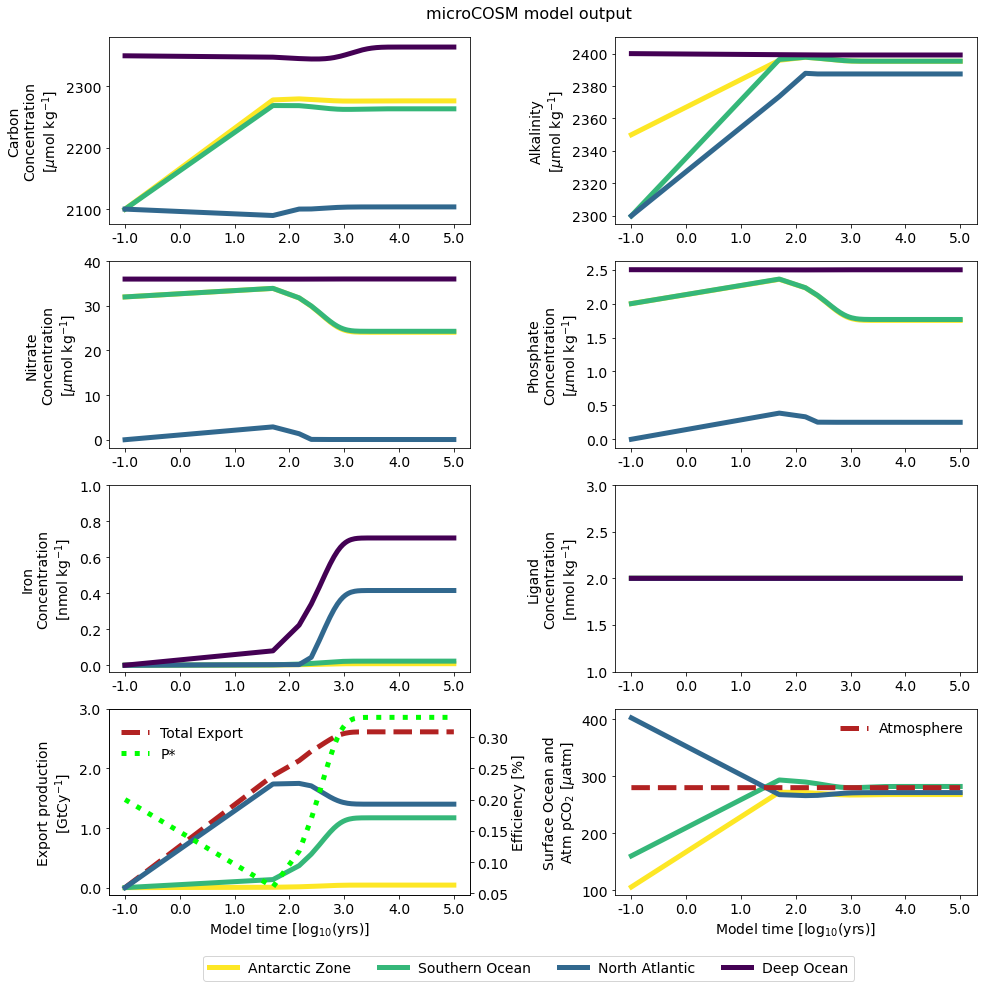

In [7]:
# Make sure initial conditions are included at t~0
timeseries1.at[0, "time"] = 1e-1

# Integrated export production
timeseries1["exp"] = timeseries1["exportaa"] + timeseries1["exportso"] + timeseries1["exportna"]

# Plot the timeseries of...
from matplotlib.ticker import FormatStrFormatter

len_xaxis, len_yaxis = 4, 4  # fix here your numbers
xspace, yspace = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig = len_xaxis / xspace, len_yaxis / yspace

f1, f1ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f1.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

# ...Carbon and Alkalinity
for ii,name in enumerate(names):
    f1ax[0, 0].plot(
        np.log10(timeseries1["time"]),
        timeseries1["c"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[0, 0].set_ylim(top=np.ceil(np.max(f1ax[0, 0].get_ylim()) / 10) * 10)
f1ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 0].set_ylabel("Carbon\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f1ax[0, 1].plot(
        np.log10(timeseries1["time"]),
        timeseries1["a"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[0, 1].set_ylim(top=np.ceil(np.max(f1ax[0, 1].get_ylim()) / 10) * 10)
f1ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 1].set_ylabel("Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Macronutrients
for ii,name in enumerate(names):
    f1ax[1, 0].plot(
        np.log10(timeseries1["time"]),
        timeseries1["n"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[1, 0].set_ylim(top=np.ceil(np.max(f1ax[1, 0].get_ylim()) / 10) * 10)
f1ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 0].set_ylabel("Nitrate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f1ax[1, 1].plot(
        np.log10(timeseries1["time"]),
        timeseries1["p"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[1, 1].set_xlim(left=np.min(f1ax[1, 0].get_xlim()))
f1ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 1].set_ylabel("Phosphate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Iron/Ligands
for ii,name in enumerate(names):
    f1ax[2, 0].plot(
        np.log10(timeseries1["time"]),
        timeseries1["f"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[2, 0].set_ylim(top=np.ceil(np.max(f1ax[2, 0].get_ylim())))
f1ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 0].set_ylabel("Iron\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f1ax[2, 1].plot(
        np.log10(timeseries1["time"]),
        timeseries1["l"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f1ax[2, 1].set_ylim(top=np.ceil(np.max(f1ax[2, 1].get_ylim())),
                 bottom=np.max([0.0,lig_conc-1.0]))
f1ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].set_ylabel("Ligand\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

# ...Export/pstar
# Total
f1ax[3, 0].plot(
    np.log10(timeseries1["time"]),
    timeseries1["exp"],
    color="firebrick",
    linewidth=5,
    linestyle="--",
    label="Total Export",
)
for ii,name in enumerate({n: names[n] for n in ["AA","SO","NA"] if n in names}):
    f1ax[3, 0].plot(
        np.log10(timeseries1["time"]),
        timeseries1["export"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        #label=names[name],
    )
# PS
f1ax30b = f1ax[3, 0].twinx()
f1ax30b.plot(
    np.log10(timeseries1["time"]),
    timeseries1["pstar"],
    color="lime",
    linewidth=5,
    linestyle=":",
    label="P*",
)
f1ax[3, 0].legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.30),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax30b.legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.28),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax[3, 0].set_ylim(top=np.ceil(np.max(f1ax[3, 0].get_ylim())))
f1ax[3, 0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].set_ylabel("Export production\n[GtCy$^{-1}$]", fontsize=14)
f1ax30b.   set_ylabel("Efficiency [%]", fontsize=14)
f1ax[3, 0].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# ...pCO2
for ii,name in enumerate({n: names[n] for n in ["AA","SO","NA"] if n in names}):
    f1ax[3, 1].plot(
        np.log10(timeseries1["time"]),
        timeseries1["pco2"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        #label=names[name],
    )
# ATM
f1ax[3, 1].plot(
    np.log10(timeseries1["time"]),
    timeseries1["atmpco2"],
    color='firebrick',
    linewidth=5,
    linestyle="--",
    label="Atmosphere",
)
f1ax[3, 1].legend(frameon=False, fontsize=14)
f1ax[3, 1].set_ylim(top=np.ceil(np.max(f1ax[3, 1].get_ylim())))
f1ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 1].set_ylabel("Surface Ocean and\nAtm pCO$_2$ [$\mu$atm]", fontsize=14)
f1ax[3, 1].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# Add global box legend at the bottom
f1ax[0, 0].legend(frameon=True, fontsize=14, ncol=len(dz), loc='center', bbox_transform=f1.transFigure,bbox_to_anchor=(0.5, 0.055))

plt.suptitle("microCOSM model output", fontsize=16)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4, top=0.95)
plt.show()

# save the graph
f1.savefig(
    "microCOSM_" + fadd + "_spinup_timeseries1.pdf",
    format="pdf",
    facecolor=f1.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

In [8]:
#model_input['alphabio'] = np.array((3e-6,))
#parm       ['alphabio'] = np.array((3e-6,))

model_input["sourceFe"] = [np.array([1.5e-3/20., 1.5e-3/20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
parm       ["sourceFe"] = [np.array([1.5e-3/20., 1.5e-3/20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]

#fadd                    = fadd.replace('4box','4boxdeca')
fadd                    = fadd.replace('4box','4boxdecdust')

timeseries2 = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries2[["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : timeseries2[["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : timeseries2[["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": timeseries2[["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : timeseries2[["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries2[["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : timeseries2[["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : timeseries2[["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries2['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

In [9]:
#model_input['alphabio'] = np.array((9e-6,))
#parm       ['alphabio'] = np.array((9e-6,))
#fadd                    = fadd.replace('4boxdeca','4boxinca')

model_input["sourceFe"] = [np.array([1.5e-3*20., 1.5e-3*20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
parm       ["sourceFe"] = [np.array([1.5e-3*20., 1.5e-3*20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
fadd                    = fadd.replace('4boxdecdust','4boxincdust')

timeseries3 = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries3[["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : timeseries3[["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : timeseries3[["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": timeseries3[["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : timeseries3[["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries3[["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : timeseries3[["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : timeseries3[["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries3['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

### Change gamma/lambda and gamma for variable ligand control experiment

In [10]:
fadd, lig_gamma, lig_lambda, lig_conc = get_ligand_parameters(fadd='4box',gamma_over_lambda=4398.0,gamma=5.0e-5,lig_conc=2.0,R_cp=106.0)
model_input['gamma']  = lig_gamma
parm       ['gamma']  = lig_gamma
model_input['lambda'] = lig_lambda
parm       ['lambda'] = lig_lambda
model_input['ligand'] = pd.Series([np.ones ((len(dz),)) * lig_conc])

# reset alphabio
#model_input['alphabio'] = np.array((6e-6,))
#parm       ['alphabio'] = np.array((6e-6,))

model_input["sourceFe"] = [np.array([1.5e-3, 1.5e-3, 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
parm       ["sourceFe"] = [np.array([1.5e-3, 1.5e-3, 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]

timeseries4 = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries4[["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : timeseries4[["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : timeseries4[["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": timeseries4[["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : timeseries4[["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries4[["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : timeseries4[["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : timeseries4[["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries4['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

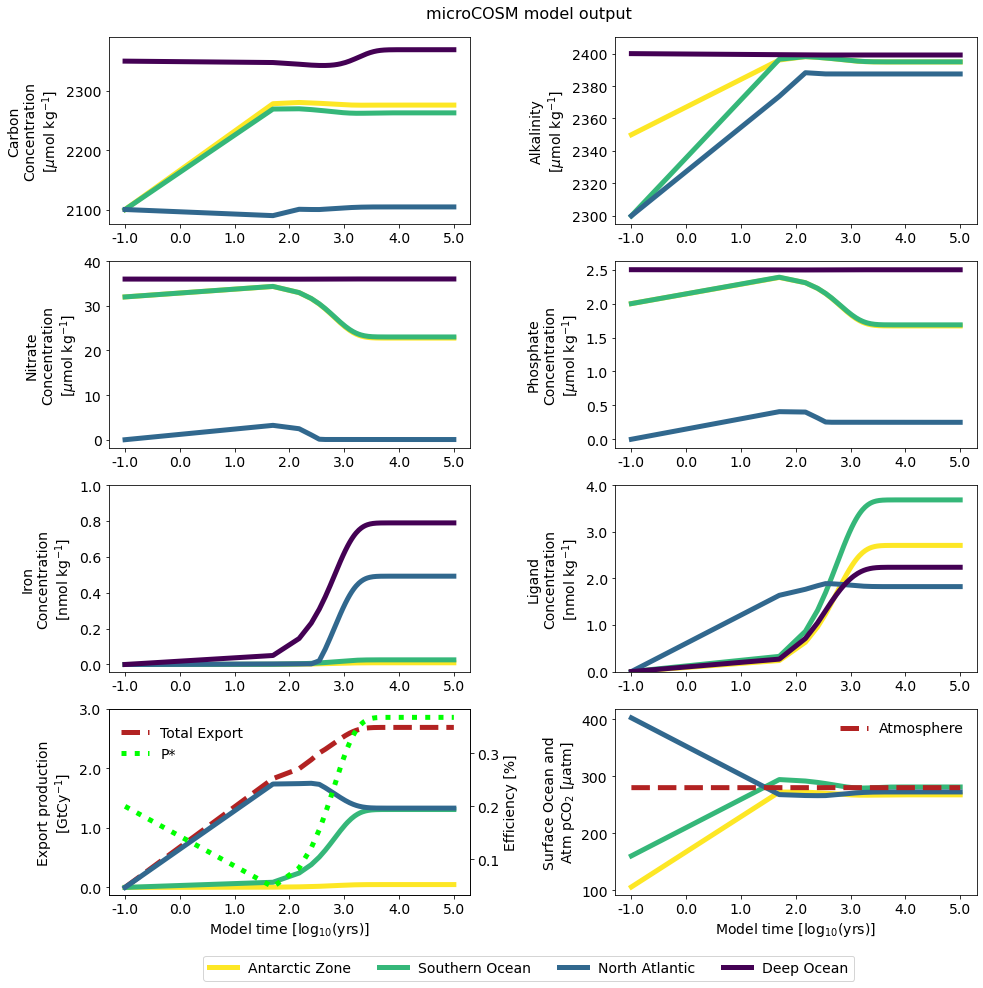

In [11]:
# Make sure initial conditions are included at t~0
timeseries4.at[0, "time"] = 1e-1

# Integrated export production
timeseries4["exp"] = timeseries4["exportaa"] + timeseries4["exportso"] + timeseries4["exportna"]

# Plot the timeseries of...
from matplotlib.ticker import FormatStrFormatter

len_xaxis, len_yaxis = 4, 4  # fix here your numbers
xspace, yspace = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig = len_xaxis / xspace, len_yaxis / yspace

f2, f2ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f2.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis_r")

# ...Carbon and Alkalinity
for ii,name in enumerate(names):
    f2ax[0, 0].plot(
        np.log10(timeseries4["time"]),
        timeseries4["c"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[0, 0].set_ylim(top=np.ceil(np.max(f2ax[0, 0].get_ylim()) / 10) * 10)
f2ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 0].set_ylabel("Carbon\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f2ax[0, 1].plot(
        np.log10(timeseries4["time"]),
        timeseries4["a"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[0, 1].set_ylim(top=np.ceil(np.max(f2ax[0, 1].get_ylim()) / 10) * 10)
f2ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[0, 1].set_ylabel("Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Macronutrients
for ii,name in enumerate(names):
    f2ax[1, 0].plot(
        np.log10(timeseries4["time"]),
        timeseries4["n"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[1, 0].set_ylim(top=np.ceil(np.max(f2ax[1, 0].get_ylim()) / 10) * 10)
f2ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 0].set_ylabel("Nitrate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f2ax[1, 1].plot(
        np.log10(timeseries4["time"]),
        timeseries4["p"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[1, 1].set_xlim(left=np.min(f2ax[1, 0].get_xlim()))
f2ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[1, 1].set_ylabel("Phosphate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Iron/Ligands
for ii,name in enumerate(names):
    f2ax[2, 0].plot(
        np.log10(timeseries4["time"]),
        timeseries4["f"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[2, 0].set_ylim(top=np.ceil(np.max(f2ax[2, 0].get_ylim())))
f2ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 0].set_ylabel("Iron\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

for ii,name in enumerate(names):
    f2ax[2, 1].plot(
        np.log10(timeseries4["time"]),
        timeseries4["l"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        label=names[name],
    )
f2ax[2, 1].set_ylim(top=np.ceil(np.max(f2ax[2, 1].get_ylim())),
                 bottom=np.max([0.0,lig_conc-1.0]))
f2ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[2, 1].set_ylabel("Ligand\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

# ...Export/pstar
# Total
f2ax[3, 0].plot(
    np.log10(timeseries4["time"]),
    timeseries4["exp"],
    color="firebrick",
    linewidth=5,
    linestyle="--",
    label="Total Export",
)
for ii,name in enumerate({n: names[n] for n in ["AA","SO","NA"] if n in names}):
    f2ax[3, 0].plot(
        np.log10(timeseries4["time"]),
        timeseries4["export"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        #label=names[name],
    )
# PS
f2ax30b = f2ax[3, 0].twinx()
f2ax30b.plot(
    np.log10(timeseries4["time"]),
    timeseries4["pstar"],
    color="lime",
    linewidth=5,
    linestyle=":",
    label="P*",
)
f2ax[3, 0].legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.30),
    bbox_transform=f2.transFigure,
    frameon=False,
    fontsize=14,
)
f2ax30b.legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.28),
    bbox_transform=f2.transFigure,
    frameon=False,
    fontsize=14,
)
f2ax[3, 0].set_ylim(top=np.ceil(np.max(f2ax[3, 0].get_ylim())))
f2ax[3, 0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 0].set_ylabel("Export production\n[GtCy$^{-1}$]", fontsize=14)
f2ax30b.   set_ylabel("Efficiency [%]", fontsize=14)
f2ax[3, 0].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# ...pCO2
for ii,name in enumerate({n: names[n] for n in ["AA","SO","NA"] if n in names}):
    f2ax[3, 1].plot(
        np.log10(timeseries4["time"]),
        timeseries4["pco2"+name.lower()],
        color=mycm(ii/(len(names)-1)),
        linewidth=5,
        #label=names[name],
    )
# ATM
f2ax[3, 1].plot(
    np.log10(timeseries4["time"]),
    timeseries4["atmpco2"],
    color='firebrick',
    linewidth=5,
    linestyle="--",
    label="Atmosphere",
)
f2ax[3, 1].legend(frameon=False, fontsize=14)
f2ax[3, 1].set_ylim(top=np.ceil(np.max(f2ax[3, 1].get_ylim())))
f2ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f2ax[3, 1].set_ylabel("Surface Ocean and\nAtm pCO$_2$ [$\mu$atm]", fontsize=14)
f2ax[3, 1].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# Add global box legend at the bottom
f2ax[0, 0].legend(frameon=True, fontsize=14, ncol=len(dz), loc='center', bbox_transform=f2.transFigure,bbox_to_anchor=(0.5, 0.055))

plt.suptitle("microCOSM model output", fontsize=16)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4, top=0.95)
plt.show()

# save the graph
f2.savefig(
    "microCOSM_" + fadd + "_spinup_timeseries.pdf",
    format="pdf",
    facecolor=f2.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

In [12]:
#model_input['alphabio'] = np.array((3e-6,))
#parm       ['alphabio'] = np.array((3e-6,))
#fadd                    = fadd.replace('4box','4boxdeca')

model_input["sourceFe"] = [np.array([1.5e-3/20., 1.5e-3/20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
parm       ["sourceFe"] = [np.array([1.5e-3/20., 1.5e-3/20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
fadd                    = fadd.replace('4box','4boxdecdust')

timeseries5 = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries5[["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : timeseries5[["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : timeseries5[["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": timeseries5[["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : timeseries5[["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries5[["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : timeseries5[["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : timeseries5[["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries5['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

In [13]:
#model_input['alphabio'] = np.array((9e-6,))
#parm       ['alphabio'] = np.array((9e-6,))
#fadd                    = fadd.replace('4boxdeca','4boxinca')

model_input["sourceFe"] = [np.array([1.5e-3*20., 1.5e-3*20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
parm       ["sourceFe"] = [np.array([1.5e-3*20., 1.5e-3*20., 1.5e-1, (1e9 * 56) / (area[3] * 2.5e-3)])]
fadd                    = fadd.replace('4boxdecdust','4boxincdust')

timeseries6 = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=["time"]\
                        +["t" + name.lower() for name in names]\
                        +["s" + name.lower() for name in names]\
                        +["c" + name.lower() for name in names]\
                        +["a" + name.lower() for name in names]\
                        +["p" + name.lower() for name in names]\
                        +["n" + name.lower() for name in names]\
                        +["f" + name.lower() for name in names]\
                        +["l" + name.lower() for name in names]\
                        +["export" + name.lower() for name in names]\
                        +["lim"]\
                        +["pstar"]\
                        +["pco2" + name.lower() for name in names]\
                        +["atmpco2"],
                  ).transpose()

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries6[["t" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "salt"      : timeseries6[["s" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "carbon"    : timeseries6[["c" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "alkalinity": timeseries6[["a" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "phosphate" : timeseries6[["p" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries6[["n" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "iron"      : timeseries6[["f" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "ligand"    : timeseries6[["l" + name.lower() for name in names]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries6['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")